In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

from tqdm import tqdm

# Upload model
# from models.R1AE import ConvLRAE, ConvVAE, ConvAE


import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

import argparse

from models.evaluation import inf_by_layers, check_reconstruction, gen_idx_for_batches, display_datasets
from models.evaluation import gen_gm_dataset, update_FID_class, ManualFID, prepare_to_FID, get_inf_by_layers
from models.evaluation import get_MSE_PSNR_score, calculate_FID

# from torchmetrics.image.fid import FrechetInceptionDistance as tm_FrechetInceptionDistance
# from torcheval.metrics import FrechetInceptionDistance

# from sklearn.mixture import GaussianMixture

from timeit import default_timer as timer

from utils.script_utils import setup_dataset_eval, update_out_file, plot_loss, select_dataset, init_model, upload_checkpoint_in
from main_utils import get_models_class_list, get_base_model_parameters, get_eval_parameters

/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# timer_start = timer() # start timer

#default
GOOD_DATASET_TYPE = ['MNIST', 'CIFAR10', 'CELEBA', 'FMNIST', 'FASHIONMNIST']
GOOD_MODEL_TYPE = ['VAE', 'AE', 'LRAE', 'IRMAE']
GOOD_ARCHITECTURE_TYPE = ['V1', 'NISP']

## Script setup

In [194]:
###### Setup script


## Main work parameters
DEVICE = 'cuda:2'
# MODEL_TYPE = args.model

LOAD_PATH = r"test_NIPS/data_n/test_NIPS__MNIST__LRAE__128__0.1__100.pth"



OUT_DIR = "./"

OUT_FILE_NAME = None
# print('OUT_FILE_NAME:', 'is None' if OUT_FILE_NAME is None else OUT_FILE_NAME)




ARCHITECTURE_TYPE = 'NIPS'


In [195]:
load_path = LOAD_PATH
# model_name = os.path.basename(load_path)
model_name = os.path.splitext(os.path.basename(load_path))[0]
model_dir = os.path.dirname(load_path)
MODEL_DIR = model_dir
MODEL_NAME = model_name




model_name_in_list = model_name.split('__')
DATASET_TYPE = model_name_in_list[1].upper()
MODEL_TYPE = model_name_in_list[2]
BOTTLENECK = int(model_name_in_list[3])
ALPHA = float(model_name_in_list[4])
EPOCHS = model_name_in_list[5]

print(f"Eval {load_path} was started!")


Eval test_NIPS/data_n/test_NIPS__MNIST__LRAE__128__0.1__100.pth was started!


In [196]:
models_class_list = get_models_class_list(DATASET_TYPE, ARCHITECTURE_TYPE) 

# Upload model


models_params = get_base_model_parameters(DATASET_TYPE, ARCHITECTURE_TYPE)
if models_params['BOTTLENECK'] != BOTTLENECK:
    print(f"Attention! models_params['BOTTLENECK']={models_params['BOTTLENECK']} --> {BOTTLENECK}"  )
    print(f"The BOTTLENECK={BOTTLENECK} from  the model_name={model_name} has priority!")
models_params['BOTTLENECK'] = BOTTLENECK
  
C_H_W = models_params['C_H_W']
    
    
# other Model parameters
NONLINEARITY = nn.ReLU()
models_params['NONLINEARITY'] = nn.ReLU()
###

# LRAE parameters
N_BINS, DROPOUT, TEMP, SAMPLING = 20, 0.0, 0.5, 'gumbell'
models_params = models_params | {'N_BINS': N_BINS, 'DROPOUT':DROPOUT, 'SAMPLING':SAMPLING, 'TEMP': TEMP}
##


# Testing parameters
N_FAKE_SAMPLES = 50000
TRAIN_SIZE, TEST_SIZE = -1, -1

eval_params = get_eval_parameters(DATASET_TYPE)

N_GM_COMPONENTS = eval_params['N_GM_COMPONENTS']


TEST_BATCH_SIZE_BIG = 512
TEST_BATCH_SIZE_SMALL = 128

if DEVICE in ['cuda:2', 'cuda:3', 'cuda:4']:
    TEST_BATCH_SIZE_BIG = 256
    TEST_BATCH_SIZE_SMALL = 128

if DEVICE in ['cuda:0', 'cuda:1']:
    TEST_BATCH_SIZE_BIG = 512
    TEST_BATCH_SIZE_SMALL = 512
    
if TEST_BATCH_SIZE_BIG == 1024 and DATASET_TYPE.upper() in ['CELEBA', 'CIFAR10', 'CIFAR']:
    TEST_BATCH_SIZE_BIG = 512
    





def print_params(param_list, param_names_list):
    for param_name, param in zip(param_names_list, param_list):
        print(f"{param_name}: {param}", flush=True)
    print()

models were downloaded from 'models.NIPS_R1AE_MNIST'


In [197]:

#### backup work 
BACKUP_DIR = os.path.join('files', 'dataset_checkpoints')   
print('BACKUP_DIR:', BACKUP_DIR)
checkpoint_test_dataset_path, checkpoint_train_dataset_path = None, None # initialization

###########
if not os.path.isdir(BACKUP_DIR):
    os.mkdir(BACKUP_DIR)
    print(f"BACKUP_DIR: {BACKUP_DIR} was created!")

checkpoint_test_dataset_path = os.path.join(BACKUP_DIR, f"FID_real_ckeckpoint__{DATASET_TYPE}__test.pt") 
checkpoint_train_dataset_path = os.path.join(BACKUP_DIR, f"FID_real_ckeckpoint__{DATASET_TYPE}__train.pt")  
########################   

# Show input data
print('Input script data', '\n', flush=True)
print('Main parameters:', flush=True)


in_param_list = [LOAD_PATH, DEVICE, MODEL_TYPE, DATASET_TYPE, ARCHITECTURE_TYPE, BOTTLENECK, MODEL_DIR, MODEL_NAME, OUT_FILE_NAME]
in_param__names_list = ['LOAD_PATH', 'DEVICE', 'MODEL_TYPE', 'DATASET_TYPE', 'ARCHITECTURE_TYPE', 'BOTTLENECK', 'MODEL_DIR', 'MODEL_NAME', 'OUT_FILE_NAME']
print_params(in_param_list, in_param__names_list)
print()
print()


print('All model parameters:')
# in_param_list = [BOTTLENECK, OUT_FEATURES, NONLINEARITY, IN_FEATURES,  N_BINS, DROPOUT, TEMP, SAMPLING]
# in_param__names_list = ['BOTTLENECK', 'OUT_FEATURES', 'NONLINEARITY', 'IN_FEATURES',  'N_BINS', 'DROPOUT', 'TEMP', 'SAMPLING']
# print_params(in_param_list, in_param__names_list)
print_params(models_params.values(), models_params.keys())
print()

print('Testing parameters:')
in_param_list = [N_FAKE_SAMPLES, TEST_BATCH_SIZE_BIG, TEST_BATCH_SIZE_SMALL]
in_param__names_list = ['N_FAKE_SAMPLES', 'TEST_BATCH_SIZE_BIG', 'TEST_BATCH_SIZE_SMALL']
print_params(in_param_list, in_param__names_list)
print()

print('Dataset parameters:')
in_param_list = [DATASET_TYPE, TRAIN_SIZE, TEST_SIZE]
in_param__names_list = ['DATASET_TYPE', 'TRAIN_SIZE', 'TEST_SIZE']
print_params(in_param_list, in_param__names_list)
print()


## other parameters
NUM_WORKERS = 10

# Other parameters
print('Other parameters')
other_param_list = [NUM_WORKERS, ]
other_param_names_list = ['NUM_WORKERS']
for param_name, param in zip(other_param_names_list, other_param_list):
    print(f"{param_name}: {param}")
print()



# Service parameters
# GOOD_DATASET_TYPE = ['MNIST', 'CIFAR10', 'CelebA', 'CELEBA']
# GOOD_MODEL_TYPE = ['VAE', 'AE', 'LRAE']

# Checking parameters
assert MODEL_TYPE in GOOD_MODEL_TYPE, f"Error, bad model type, select from: {GOOD_MODEL_TYPE}"
assert DATASET_TYPE in GOOD_DATASET_TYPE, f"Error, bad dataset type, select from: {GOOD_DATASET_TYPE}"
#############


BACKUP_DIR: files/dataset_checkpoints
Input script data 

Main parameters:
LOAD_PATH: test_NIPS/data_n/test_NIPS__MNIST__LRAE__128__0.1__100.pth
DEVICE: cuda:2
MODEL_TYPE: LRAE
DATASET_TYPE: MNIST
ARCHITECTURE_TYPE: NIPS
BOTTLENECK: 128
MODEL_DIR: test_NIPS/data_n
MODEL_NAME: test_NIPS__MNIST__LRAE__128__0.1__100
OUT_FILE_NAME: None



All model parameters:
IN_FEATURES: 1024
BOTTLENECK: 128
OUT_FEATURES: 8192
DS_IN_CHANNELS: 1
C_H_W: [128, 8, 8]
MIDDLE_MATRIXES: 8
NONLINEARITY: ReLU()
N_BINS: 20
DROPOUT: 0.0
SAMPLING: gumbell
TEMP: 0.5


Testing parameters:
N_FAKE_SAMPLES: 50000
TEST_BATCH_SIZE_BIG: 256
TEST_BATCH_SIZE_SMALL: 128


Dataset parameters:
DATASET_TYPE: MNIST
TRAIN_SIZE: -1
TEST_SIZE: -1


Other parameters
NUM_WORKERS: 10



# Init model

In [198]:
################# Initialization of the model
device = DEVICE
print(DEVICE)


print("Initialization of the model")
print("model_name: ", model_name, '\n\n' )

model = init_model(MODEL_TYPE, GOOD_MODEL_TYPE,  models_class_list, models_params, device)

print(f"{MODEL_TYPE} was initialized")


## model weights upload
device = DEVICE
model_path = os.path.join(model_dir, model_name + '.pth')
PATH = load_path

print('Load PATH:', PATH)
out_path_name = os.path.join(OUT_DIR, model_name)

checkpoint = upload_checkpoint_in(load_path, model=model, device=device)


print("Loaded epoch:", checkpoint['epoch'])
print("Loaded final loss:", checkpoint['loss'])


loss_list_train = checkpoint['loss_list_train']
loss_list_test = checkpoint['loss_list_test']
epoch_time_list = checkpoint['epoch_time_list'] if 'epoch_time_list' in checkpoint.keys() else None
del checkpoint

##########################################


cuda:2
Initialization of the model
model_name:  test_NIPS__MNIST__LRAE__128__0.1__100 


LRAE was initialized
Load PATH: test_NIPS/data_n/test_NIPS__MNIST__LRAE__128__0.1__100.pth
Loaded epoch: 100
Loaded final loss: 0.12022430449724197


# Dataset

In [51]:

####### Dataset
dataset_type = DATASET_TYPE
print('\n\n')
print(f'Loading dataset: {dataset_type}')


train_ds, test_ds, ds_train_size, df_test_size, ds_in_channels = select_dataset(DATASET_TYPE, GOOD_DATASET_TYPE)

# dataset and dataloader
TRAIN_SIZE = ds_train_size if TRAIN_SIZE == -1 else TRAIN_SIZE
TEST_SIZE = df_test_size if TEST_SIZE == -1 else TEST_SIZE

X_full_train, X_full_test, targets, targets_test = setup_dataset_eval(train_ds, test_ds, TRAIN_SIZE,
                                                                      TEST_SIZE,  num_workers=NUM_WORKERS)  


print("Dataset parameters:")
print(f"TRAIN_SIZE: {TRAIN_SIZE}({ds_train_size})")
print(f"TEST_SIZE: {TEST_SIZE}({df_test_size})")
# for param, param_name in zip([BATCH_SIZE], ["BATCH_SIZE"] ):
#     print(f"{param_name} = {param}")

print(f"{DATASET_TYPE} dataset logs:")
print("Img channel:", ds_in_channels)
print(X_full_train.shape)
print(torch.max(X_full_train))
print(targets.unique(return_counts=True))

print('\n\n')
###################




Loading dataset: MNIST


Dataset parameters:
TRAIN_SIZE: 60000(60000)
TEST_SIZE: 10000(10000)
MNIST dataset logs:
Img channel: 1
torch.Size([60000, 1, 32, 32])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))





# Evaluation 

In [199]:
##### EVALUATION
print('\n\nEvaluation:')

if OUT_FILE_NAME is None or OUT_FILE_NAME == '':
    out_file_path = f"{out_path_name}__metrics.txt"
else:
    out_file_path = os.path.join(OUT_DIR, OUT_FILE_NAME)
    
update_out_file(f'\n\nOut: {load_path}', out_file_path, rewrite=False)

# epoch time
if epoch_time_list is not None:
    update_out_file(f'Mean epoch time: {np.asarray(epoch_time_list).mean().item():.1f}', 
                    out_file_path, rewrite=False)



Evaluation:



Out: test_NIPS/data_n/test_NIPS__MNIST__LRAE__128__0.1__100.pth


Mean epoch time: 15.7



Figure was saved: ./test_NIPS__MNIST__LRAE__128__0.1__100__loss.jpg


(None, None)

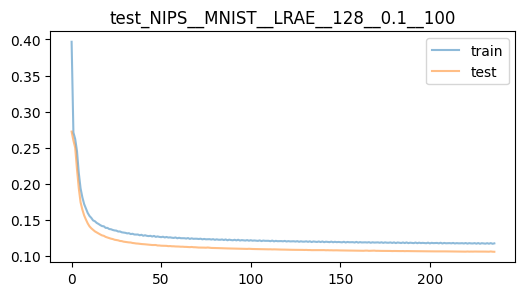

In [200]:

## Loss function
save_path_str = f"{out_path_name}__loss.jpg"

plot_loss(loss_list_train, loss_list_test)
plt.title(model_name) 
plt.savefig(save_path_str), print("Figure was saved:", save_path_str) #, plt.close() 
##########


In [201]:

## Data calculation
with torch.no_grad():
    model.eval()    
    decoded_2d1, encoded_out_dim1, factors_probability1 = get_inf_by_layers(model, X_full_train,
                                                                            batch_size=TEST_BATCH_SIZE_BIG,
                                                                            device=device, C_H_W=C_H_W)    
    decoded_2d2, encoded_out_dim2, factors_probability2 = get_inf_by_layers(model, X_full_test,
                                                                            batch_size=TEST_BATCH_SIZE_BIG,
                                                                            device=device, C_H_W=C_H_W)

############

256 x 234 + 96 == 60000(60160)


 27%|██▋       | 63/235 [00:00<00:00, 206.17it/s]

100%|██████████| 235/235 [00:01<00:00, 192.18it/s]


256 x 39 + 16 == 10000(10240)


100%|██████████| 40/40 [00:00<00:00, 235.42it/s]


##### testing

In [122]:
a = torch.nn.functional.gumbel_softmax(factors_probability1[targets==0][0], 0.5)[[9, 12]]
plt.plot(a.numpy().T)
plt.plot(torch.nn.functional.softmax(factors_probability1[targets==0][0])[[9, 12]].numpy().T, linestyle='--')
b = a@torch.arange(20, dtype=torch.float)
for ii in b:
    i = ii.item()
    plt.gca().axvline(i, linestyle='--', color='r')

IndexError: index 9 is out of bounds for dimension 0 with size 2

In [246]:
b_list[:2]

[tensor(14.2988), tensor(13.1356)]

(array([9.02795886e-02, 2.28220748e-01, 3.01478347e-01, 3.32874461e-01,
        1.91024548e-01, 7.88055068e-02, 2.95047817e-02, 6.80879579e-03,
        1.76524335e-03, 1.26088811e-04]),
 array([1.65869315e-05, 7.93108371e-01, 1.58620016e+00, 2.37929194e+00,
        3.17238372e+00, 3.96547551e+00, 4.75856729e+00, 5.55165908e+00,
        6.34475086e+00, 7.13784264e+00, 7.93093443e+00]),
 <BarContainer object of 10 artists>)

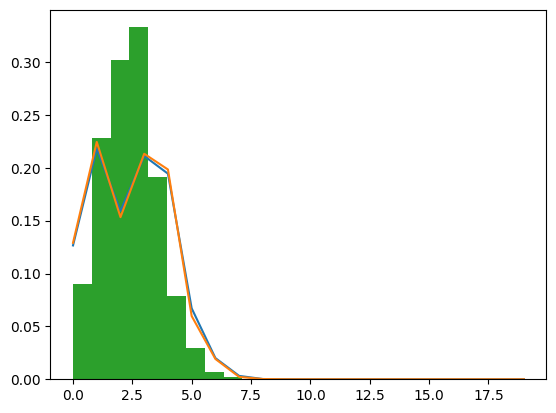

In [262]:
n = 0
cum = torch.zeros([20])
N = 10000
b_list = []
for i in range(N):
    sum_add = torch.nn.functional.gumbel_softmax(factors_probability1[targets==0][n],0.5, dim=-1)[12]
    b = sum_add@torch.arange(0, 20, dtype=torch.float)
    b_list += [b.item()]
    cum += sum_add
cum = cum / N

plt.plot(cum)
plt.plot(torch.nn.functional.softmax(factors_probability1[targets==0][n], dim=-1)[12])
plt.hist(b_list, density=True)




In [334]:
corr = np.corrcoef(torch.nn.functional.softmax(factors_probability1, dim=-1)[:,2,:].numpy())

In [353]:
corr[targets==1][:, targets==1].shape

(6742, 6742)

In [370]:
corr_.shape

(6742, 6742)

In [373]:
corr.shape

(60000, 60000)

In [374]:
h = 60000
(np.abs(corr[:h, :h])> 0.5).sum()/(h*h)*100

21.305313388888887

In [381]:
for i in range(10):
    corr_ = corr[targets==i][:, targets==i]
    h = corr_.shape[0]
    print(f"{i}: {(np.abs(corr_[:h, :h])> 0.5).sum()/(h*h)*100:.2f}%")

0: 20.57%
1: 42.87%
2: 23.86%
3: 27.35%
4: 24.08%
5: 23.56%
6: 35.83%
7: 31.18%
8: 22.02%
9: 31.43%


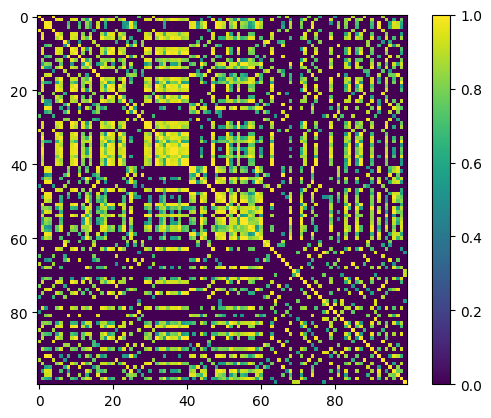

In [388]:
corr_ = corr[targets==1][:, targets==1]



plt.imshow(np.abs(corr_[:100, :100])*(np.abs(corr_[:100, :100])> 0.5))
# plt.imshow(corr_[:100, :100])
plt.colorbar()

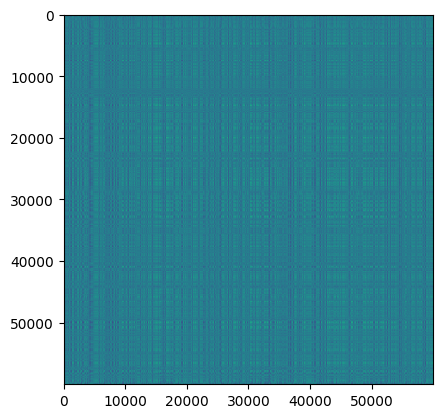

In [335]:
plt.imshow(corr)

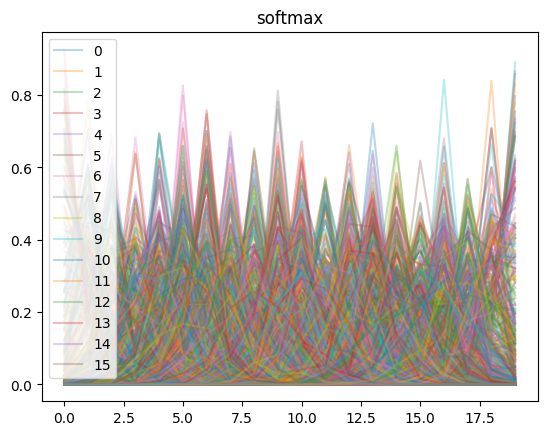

In [14]:
# plt.figure(figsize=[9, 3])
# plt.subplot(1, 3, 1)
# plt.plot(torch.nn.functional.gumbel_softmax(factors_probability1[targets==0][0]).numpy()[[9, 12]].T)
# plt.title('Gumbell')
# plt.subplot(1, 3, 2)
# plt.plot(torch.nn.functional.gumbel_softmax(factors_probability1[targets==0][0], dim=-1).numpy()[[9, 12]].T)
# plt.title('Gumbell, dim=-1')
# plt.subplot(1, 3, 3)
for jj in range(100):
    i=16
    plt.plot(torch.nn.functional.softmax(factors_probability1[jj]/0.5, dim=-1).numpy()[:i].T, alpha=0.3)
    plt.legend([str(i) for i in range(0,i)])
    plt.title('softmax')

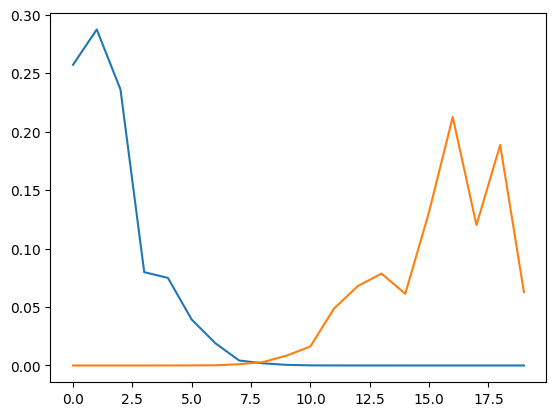

In [239]:
plt.plot(torch.nn.functional.softmax(factors_probability1[0],dim=-1).numpy()[:2,:].T)

In [257]:
(prob_dists + prob_dists_std)[0].shape

torch.Size([20])

In [264]:
prob_dists_std.sum(-1)

tensor([1.1314, 1.2804, 1.2583, 1.1939, 1.1514, 1.2272, 1.3404, 1.1709, 1.1485,
        1.2481, 1.2961, 1.1744, 1.2009, 1.0962, 1.2435, 1.2685, 1.3186, 1.1884,
        1.2178, 1.1731, 1.1119, 1.2076, 1.1287, 1.1601, 1.2532, 1.1681, 1.2229,
        1.2705, 1.2339, 1.2016, 1.2268, 1.0505, 1.1654, 1.2316, 1.1824, 1.2167,
        1.3247, 1.2861, 1.3064, 1.2051, 1.2200, 1.2947, 1.3150, 1.1380, 1.1695,
        1.2642, 1.1714, 1.1386, 1.2123, 1.2470, 1.1438, 1.1750, 1.2159, 1.1836,
        1.1668, 1.1839, 1.1667, 1.1664, 1.1638, 1.1486, 1.0810, 1.1606, 1.2899,
        1.2001, 1.1428, 1.2145, 1.2078, 1.2146, 1.1664, 1.2438, 1.2085, 1.1719,
        1.2723, 1.1354, 1.1150, 1.1561, 1.3264, 1.2079, 1.1487, 1.1833, 1.1008,
        1.3171, 1.1533, 1.2605, 1.2235, 1.1603, 1.2958, 1.1833, 1.2220, 1.2053,
        1.1888, 1.1372, 1.1911, 1.2323, 1.1358, 1.1937, 1.0486, 1.1970, 1.2582,
        1.3667, 1.3376, 1.0850, 1.1116, 1.3549, 1.1487, 1.1525, 1.2202, 1.1885,
        1.1302, 1.1067, 1.2072, 1.1235, 

### dist wort

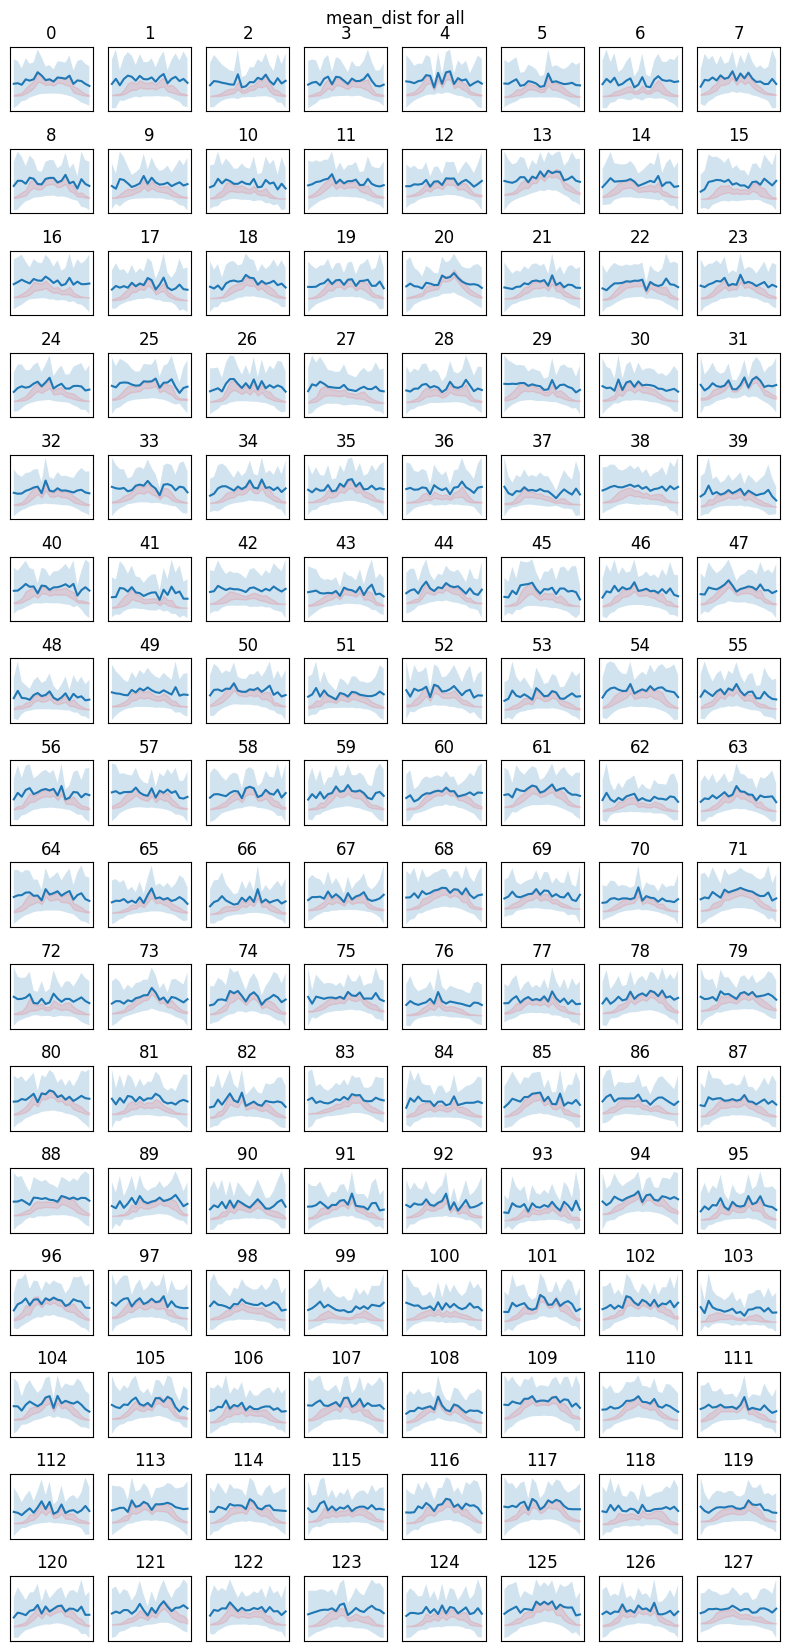

In [269]:

# for digit in range(10):
prob_dists = torch.nn.functional.softmax(factors_probability1, dim=-1).mean(0)
prob_dists_std = torch.nn.functional.softmax(factors_probability1, dim=-1).std(0)
prob_q_up = torch.nn.functional.softmax(factors_probability1, dim=-1).quantile(0.55, dim=0)
prob_q_low= torch.nn.functional.softmax(factors_probability1, dim=-1).quantile(0.45, dim=0)




px, py = 8*2, 8
fig = plt.figure(figsize=[py, px*1.05])
# plt.tight_layout(h_pad=0.5)
for i in range(prob_dists.shape[0]):
    plt.subplot(px, py, i+1)
    plt.plot(prob_dists[i])
    plt.fill_between(range(0, 20), (prob_dists + prob_dists_std).numpy()[i], (prob_dists - prob_dists_std).numpy()[i], alpha=0.2)
    plt.fill_between(range(0, 20), prob_q_up[i], prob_q_low[i], alpha=0.1,
                     color='red')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.title(i)
    # break
    
    
plt.suptitle(f'mean_dist for all')
fig.tight_layout()
plt.show()


<Figure size 1280x1310 with 0 Axes>

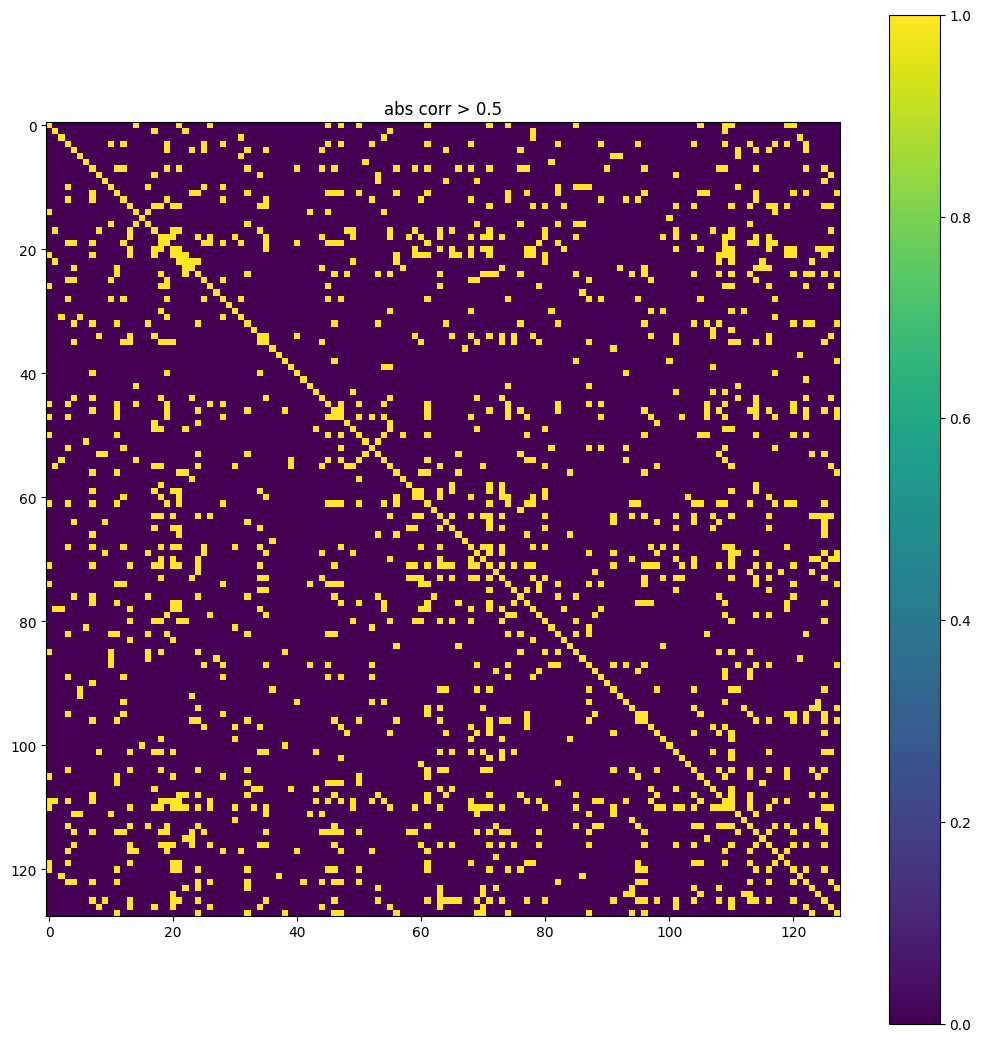

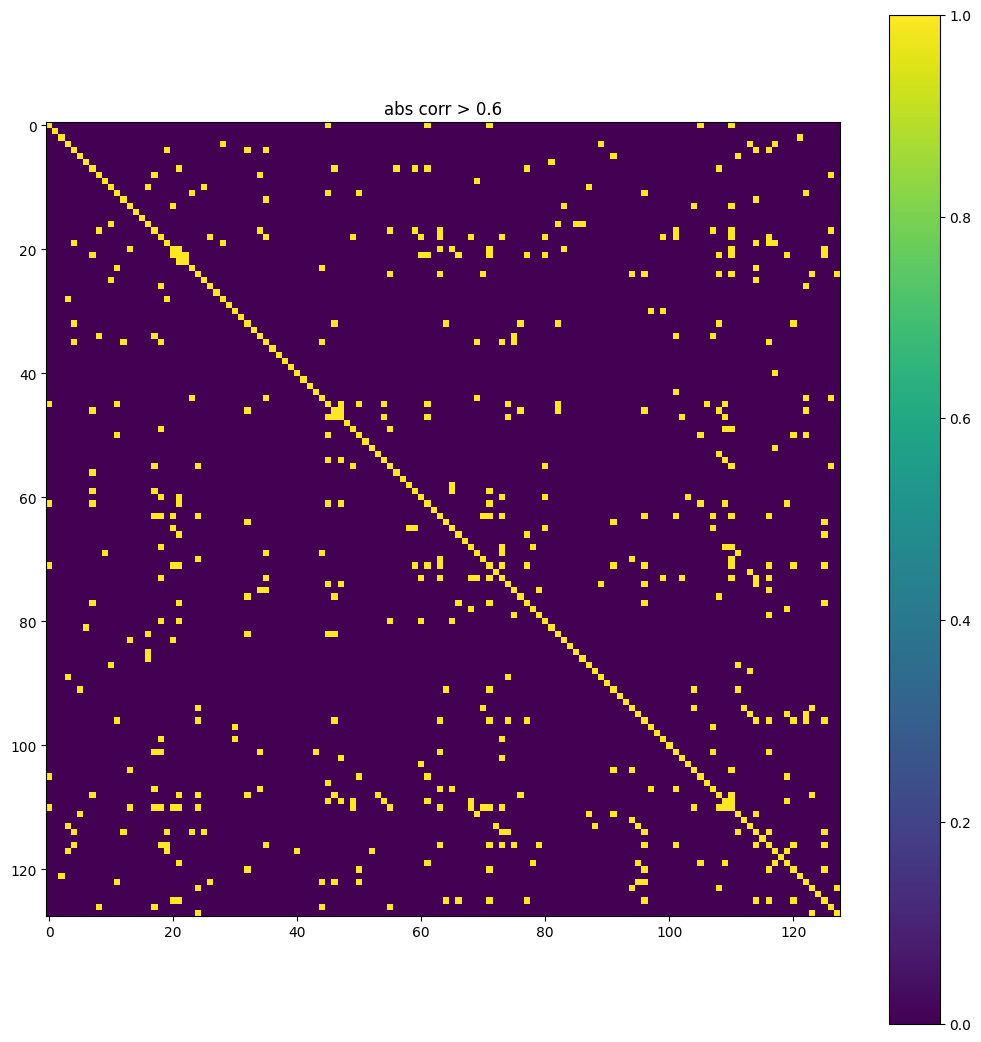

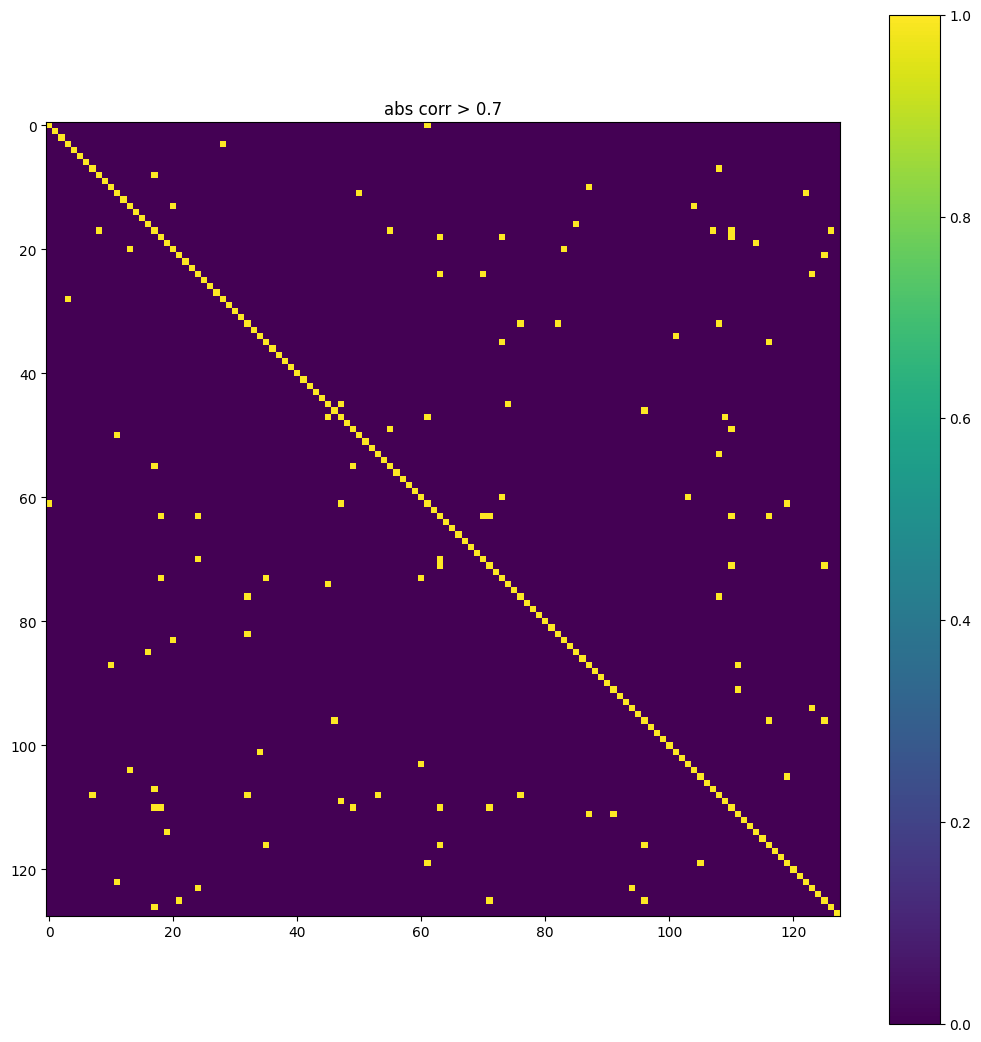

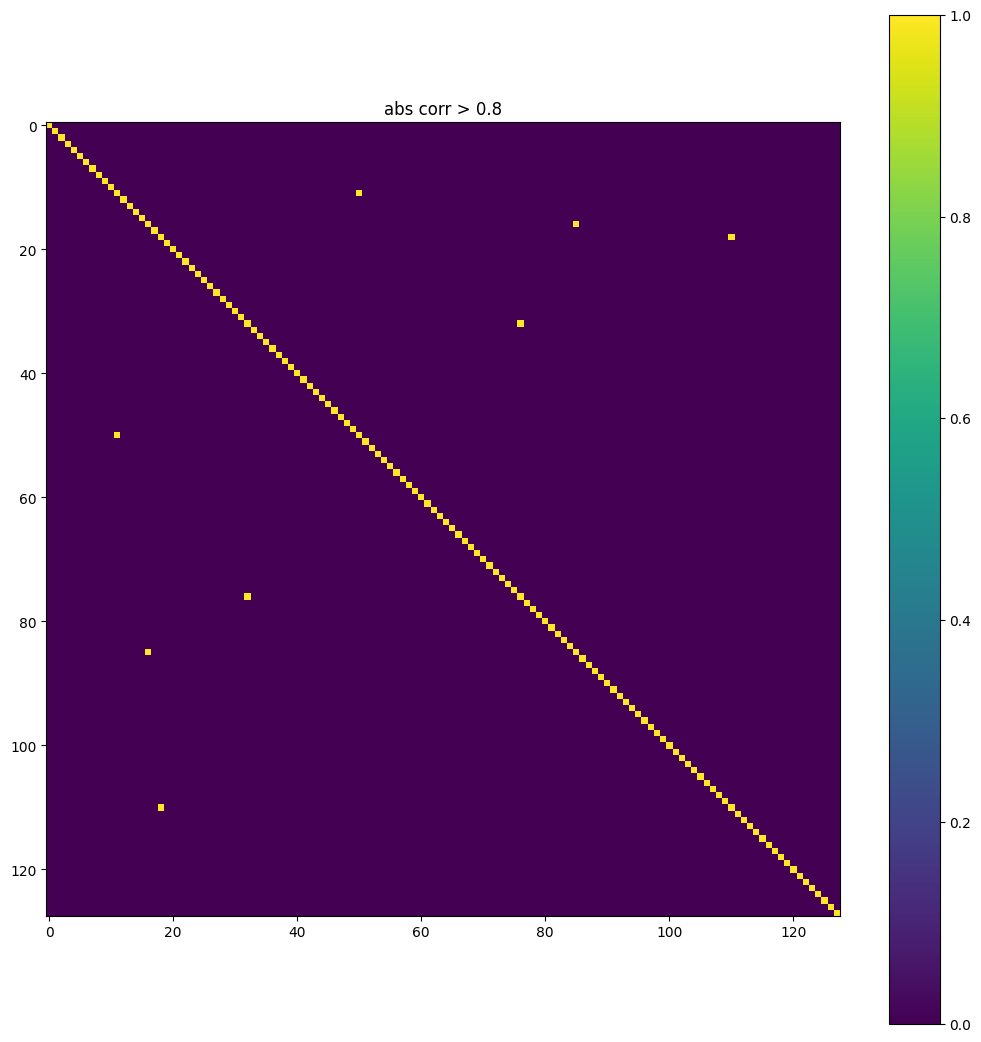

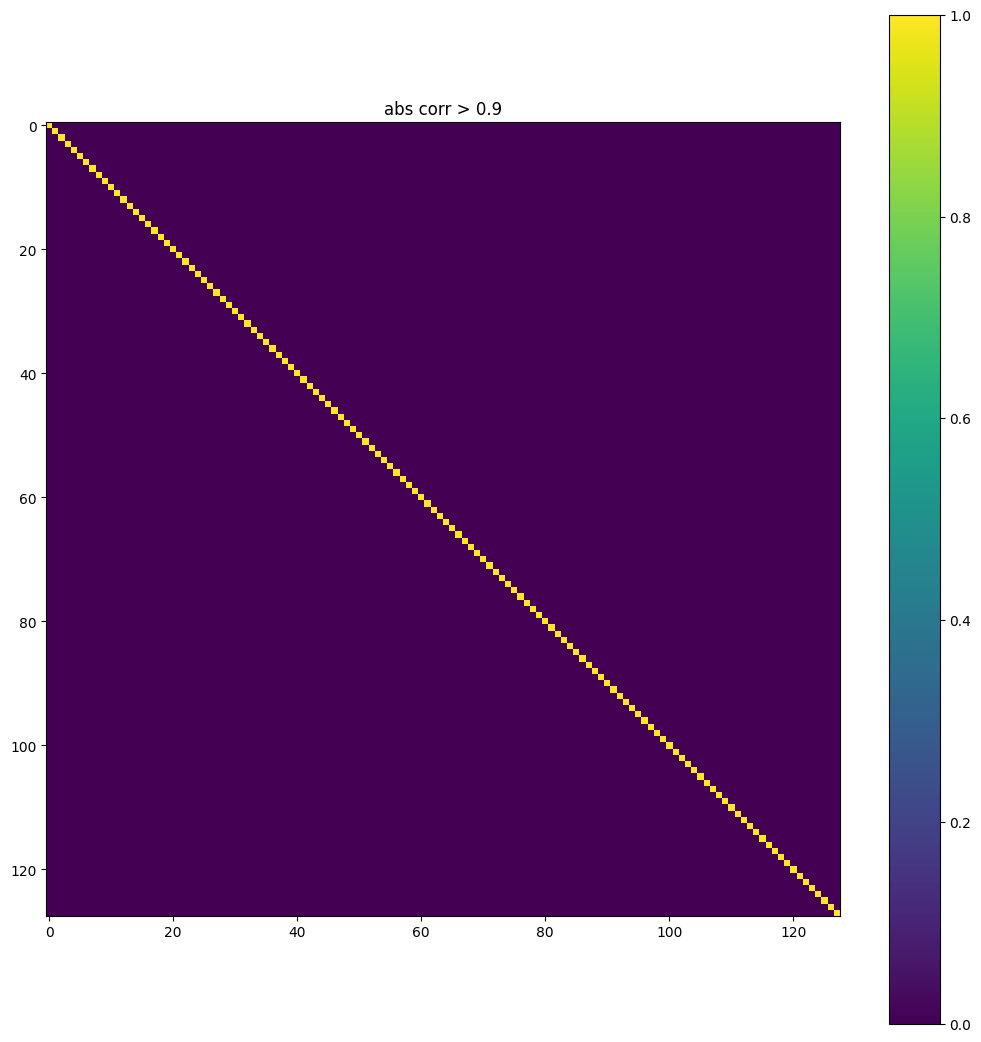

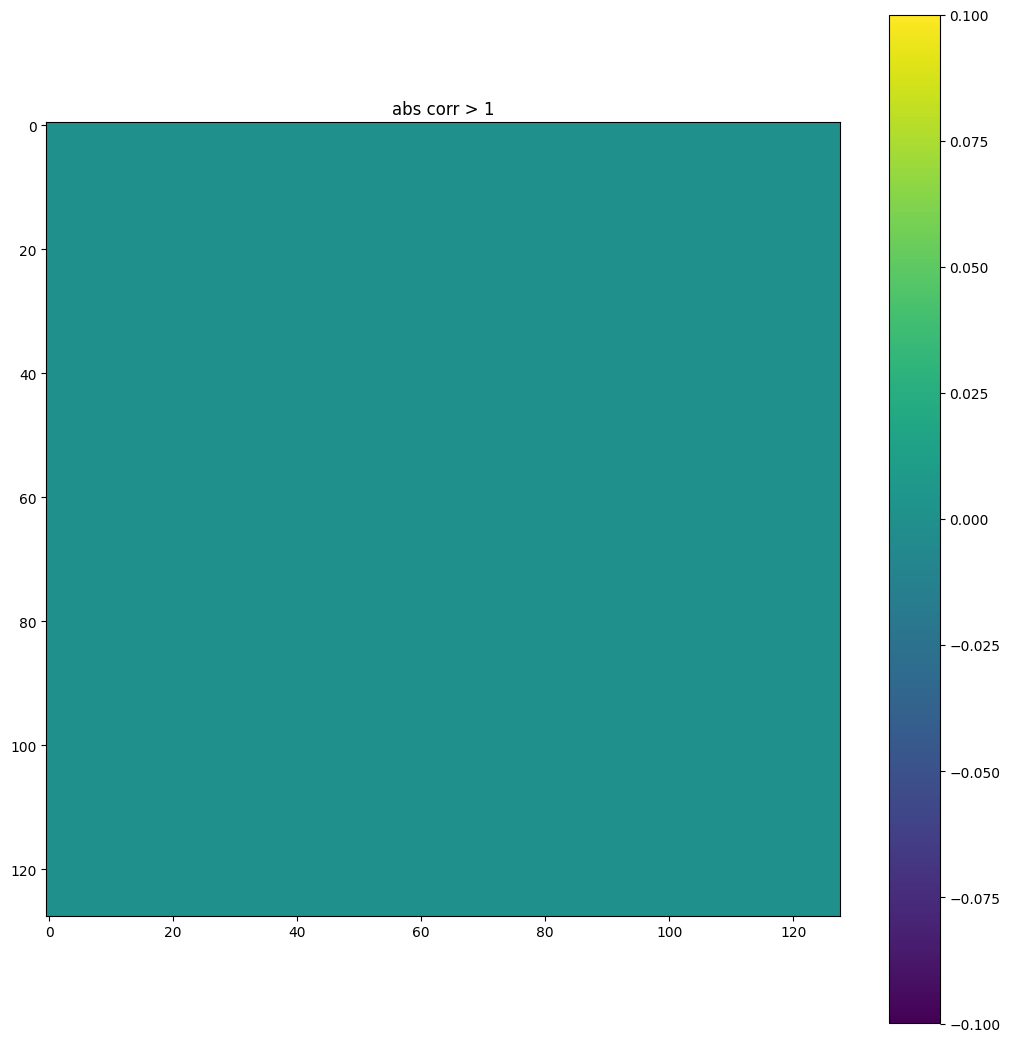

In [205]:
plt.figure(figsize=[prob_dists.shape[0]/10, prob_dists.shape[0]/10+0.3])
# plt.imshow(np.abs(np.corrcoef(prob_dists)))
for th in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    plt.figure(figsize=[prob_dists.shape[0]/10, prob_dists.shape[0]/10+0.3])
    plt.imshow(np.abs(np.corrcoef(prob_dists)) > th)
    plt.colorbar()
    plt.title(f"abs corr > {th}")
    plt.show()

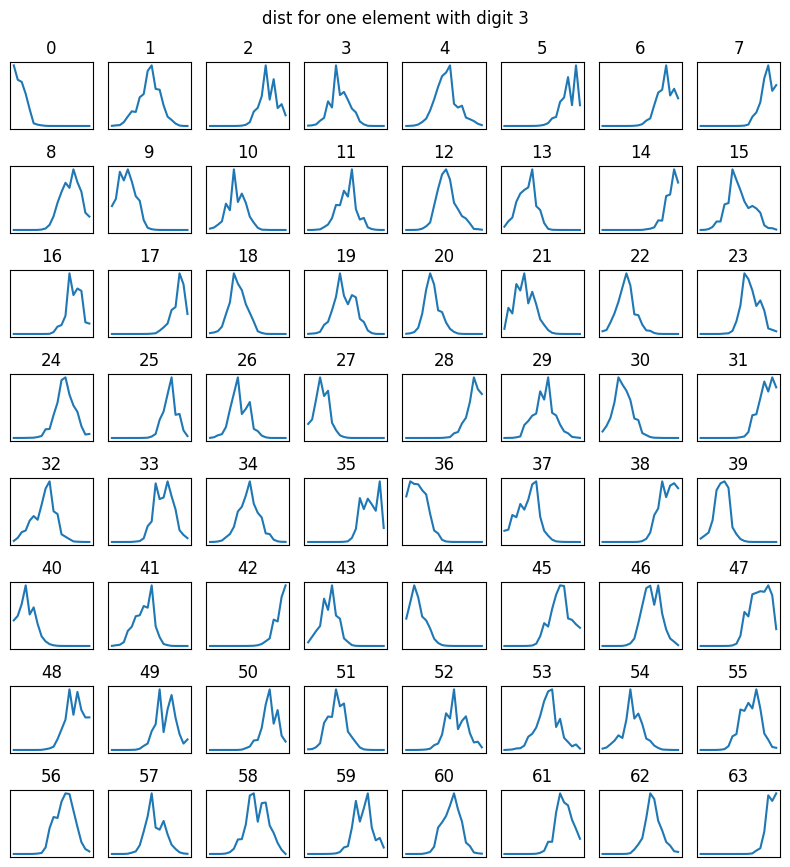

In [82]:
# Presenting prob distributions
idx = 10
prob_dists = torch.nn.functional.softmax(factors_probability1, dim=-1)[idx]


px, py = 8, 8
fig = plt.figure(figsize=[px, py*1.1])
# plt.tight_layout(h_pad=0.5)
for i in range(prob_dists.shape[0]):
    plt.subplot(px, py, i+1)
    plt.plot(prob_dists[i])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.title(i)
    
    
plt.suptitle(f'dist for one element with digit {targets[idx]}')
fig.tight_layout()
plt.show()


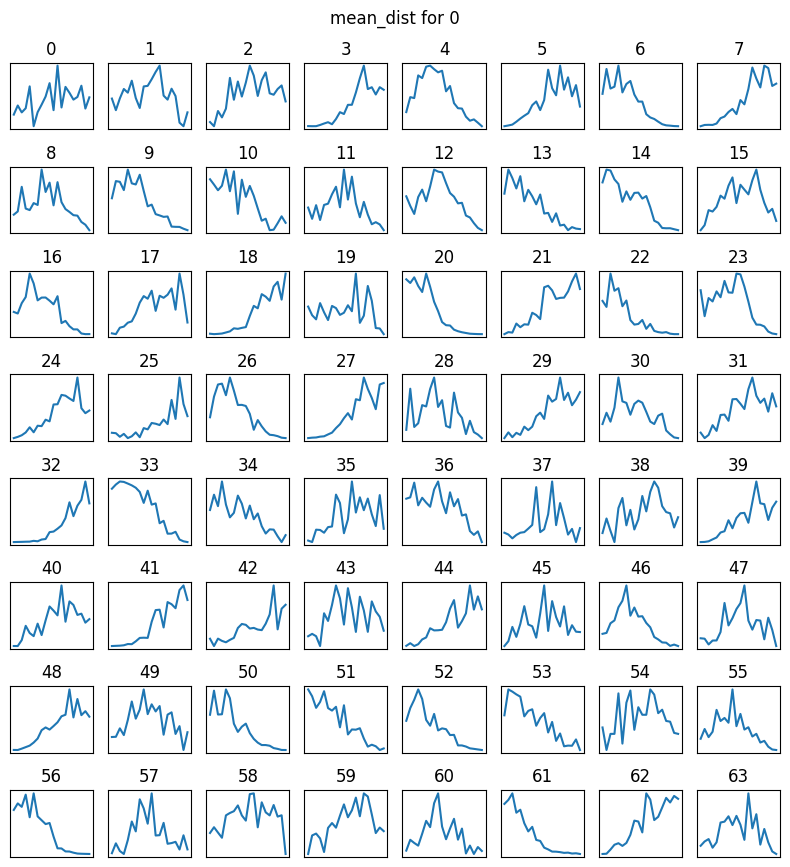

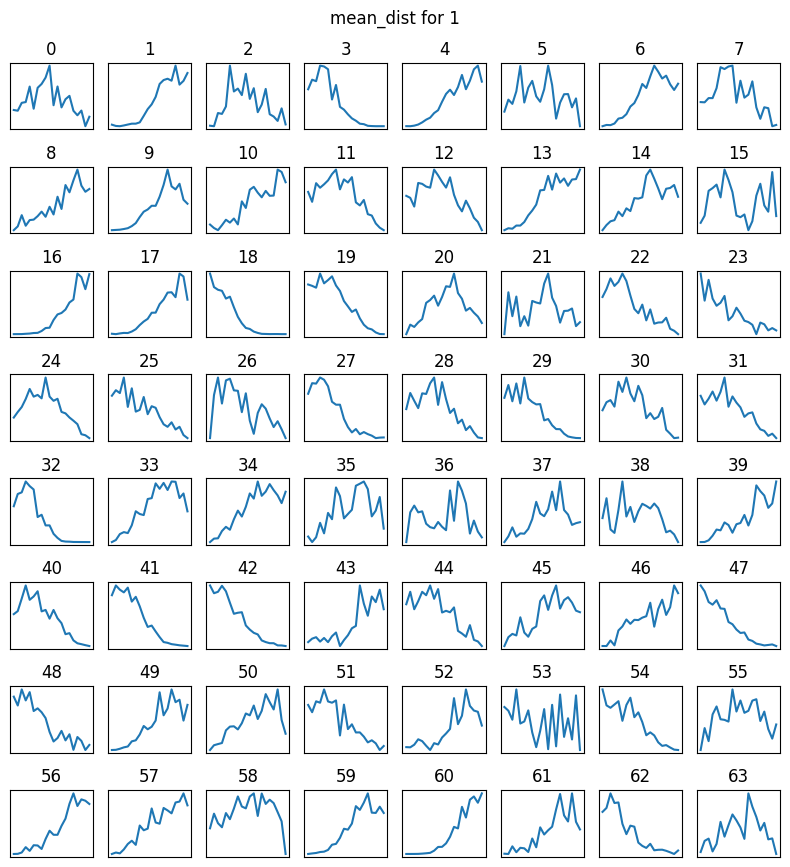

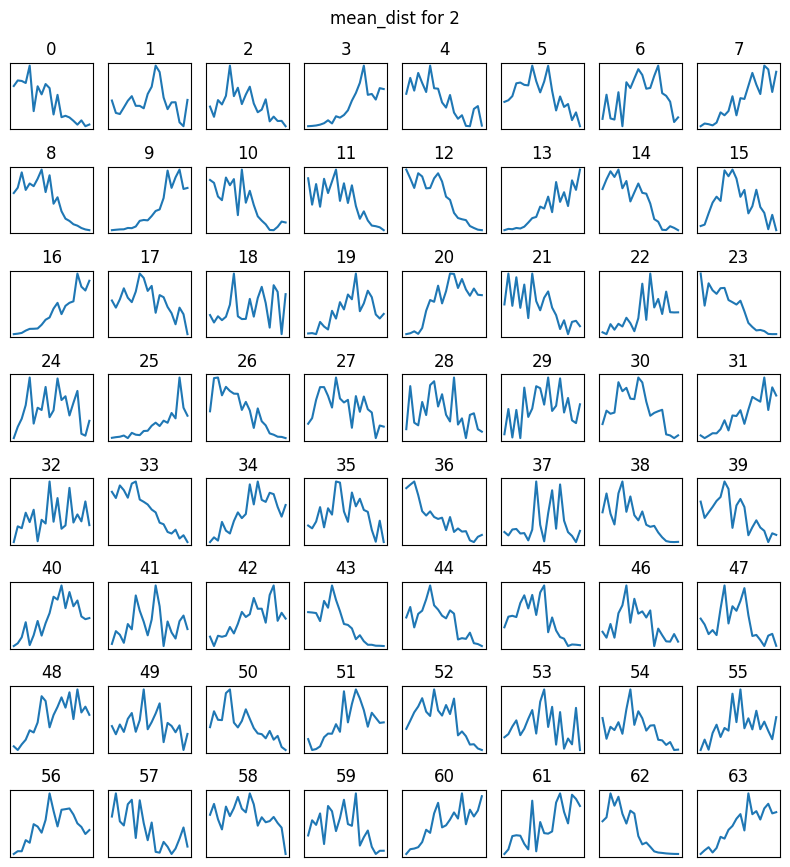

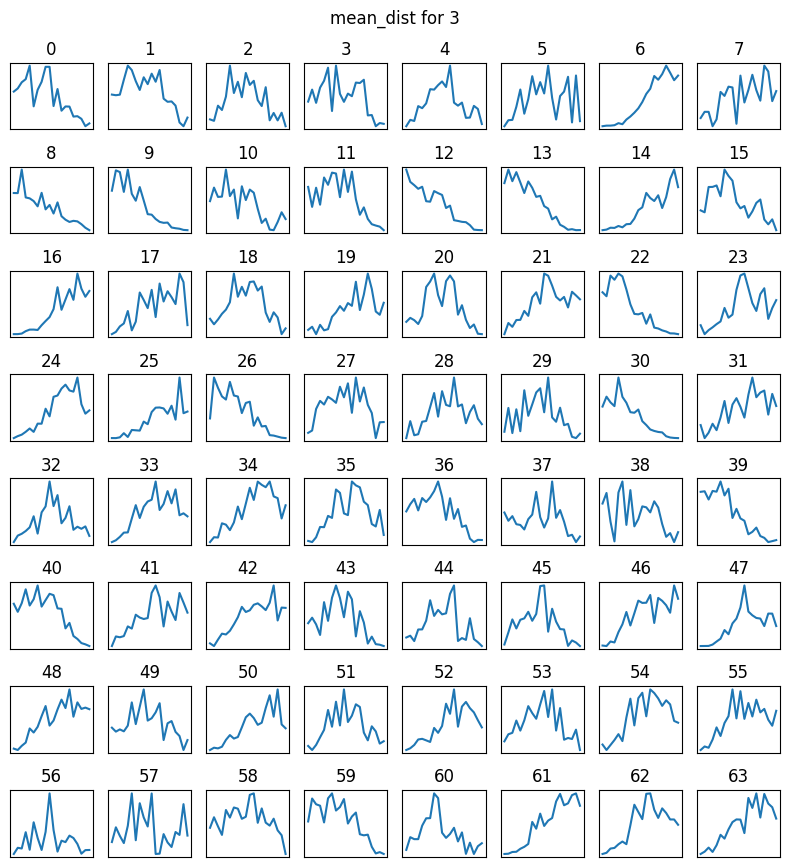

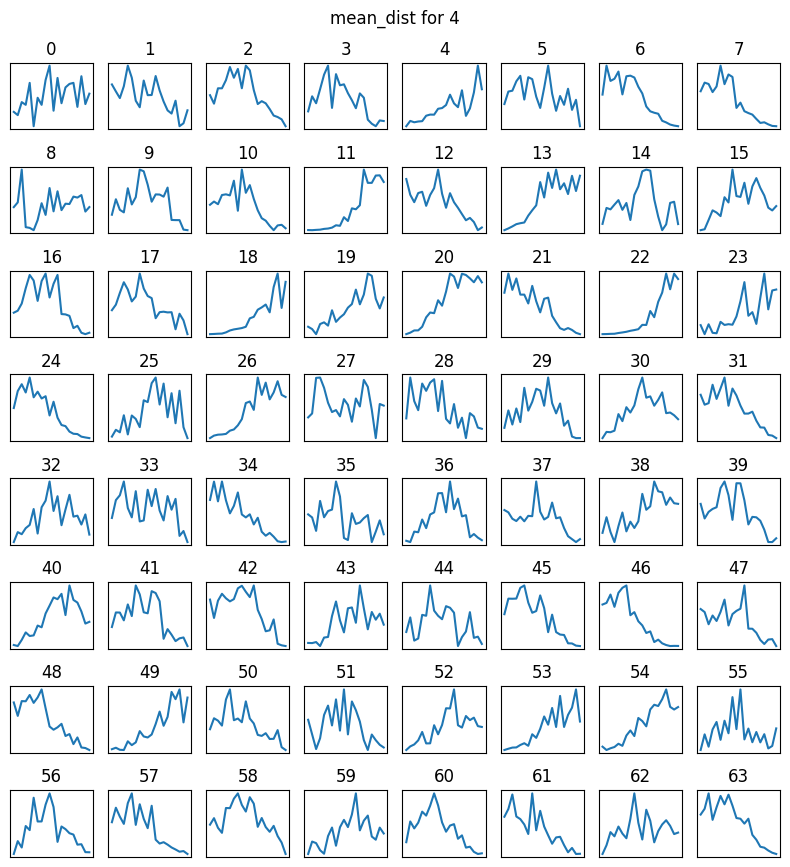

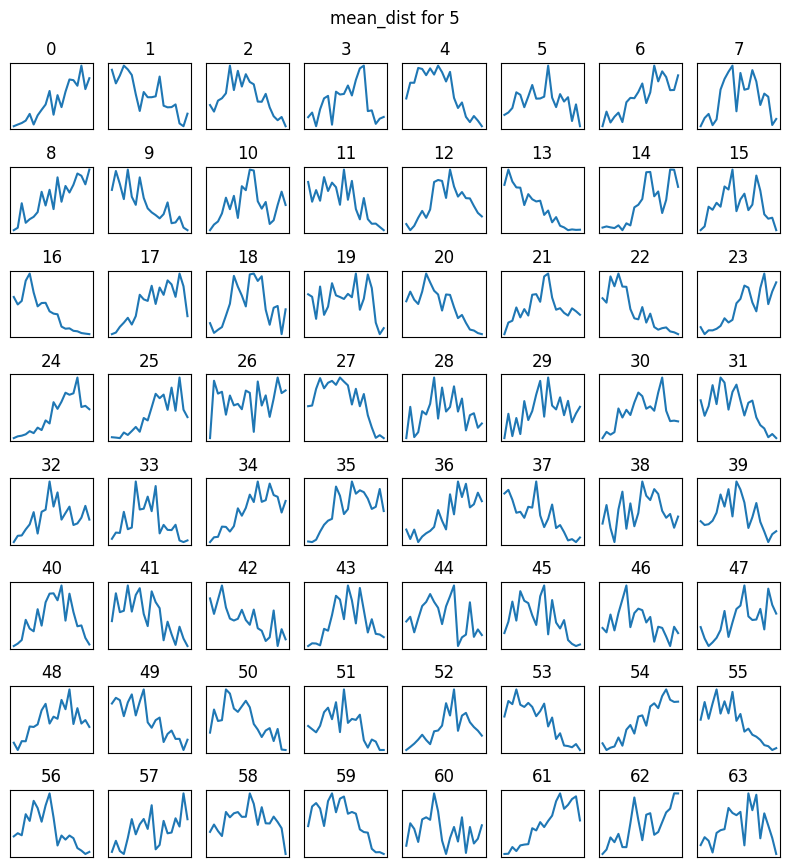

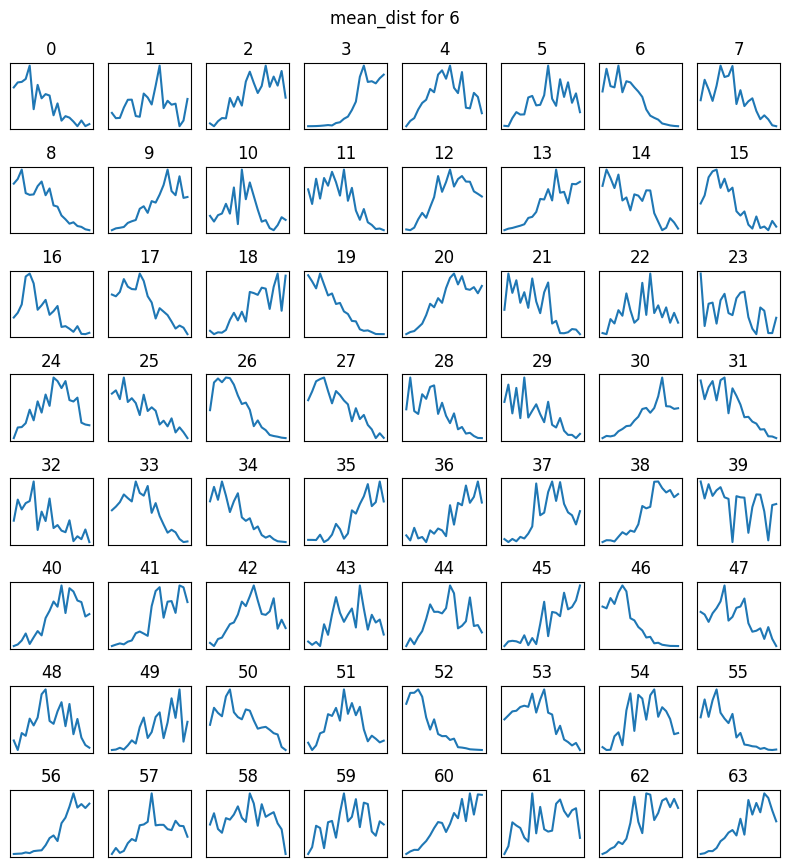

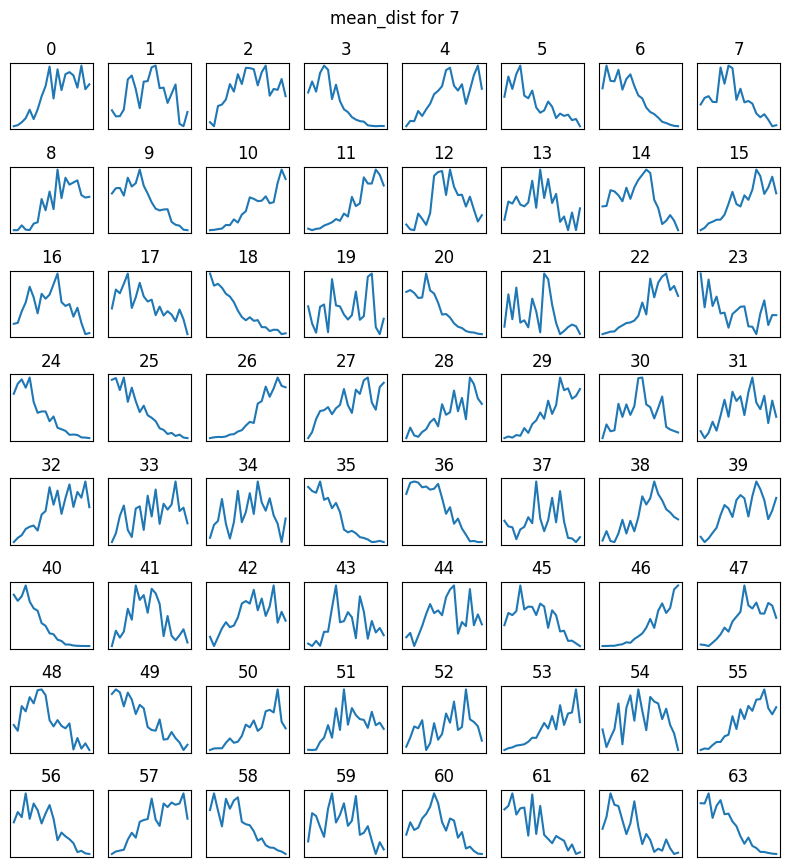

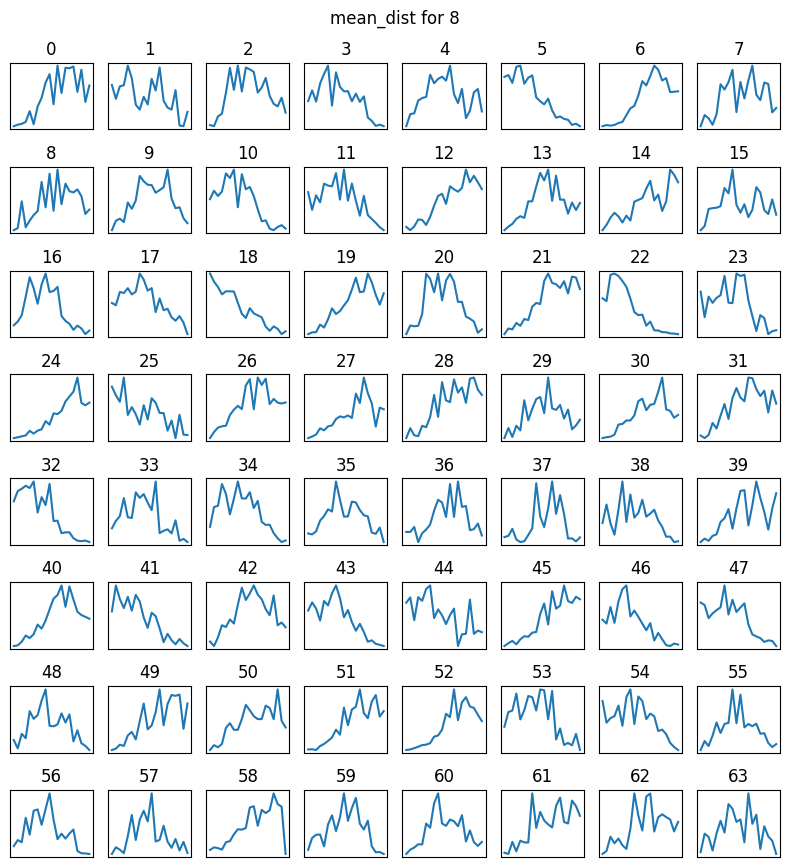

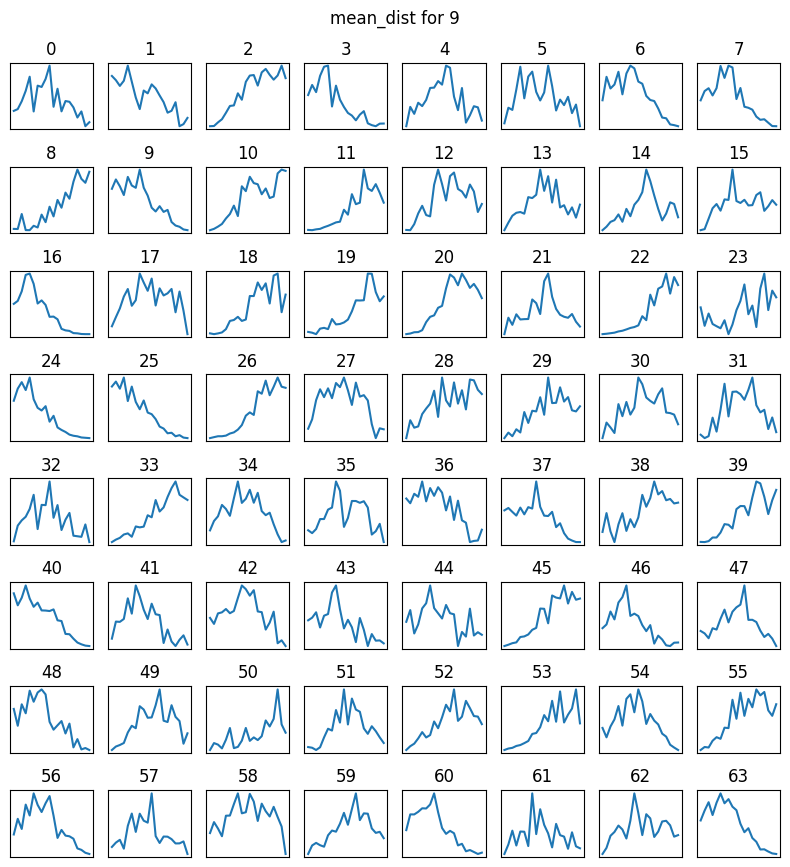

In [83]:
# Presenting prob distributions
for digit in range(10):
    prob_dists = torch.nn.functional.softmax(factors_probability1, dim=-1)[targets==digit].mean(0)


    px, py = 8, 8
    fig = plt.figure(figsize=[px, py*1.1])
    # plt.tight_layout(h_pad=0.5)
    for i in range(prob_dists.shape[0]):
        plt.subplot(px, py, i+1)
        plt.plot(prob_dists[i])
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title(i)
        
        
    plt.suptitle(f'mean_dist for {digit}')
    fig.tight_layout()
    plt.show()

    
    



### Reconstruction

Figure was saved: ./test_NIPS__MNIST__LRAE__16__0.1__100__rec_test.jpg
Figure was saved: ./test_NIPS__MNIST__LRAE__16__0.1__100__rec_train.jpg


(None, None)

<Figure size 640x480 with 0 Axes>

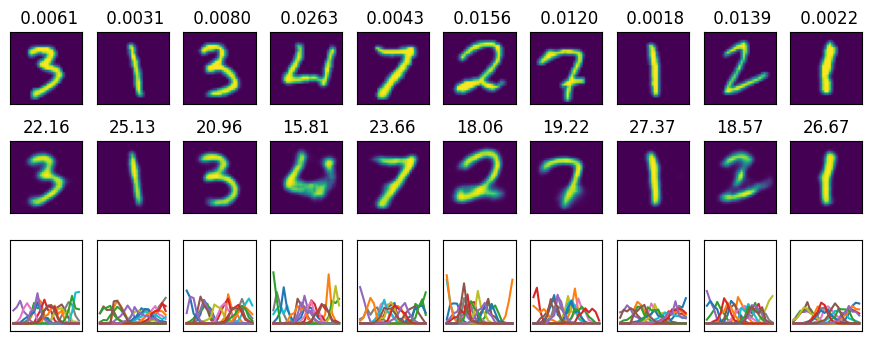

<Figure size 640x480 with 0 Axes>

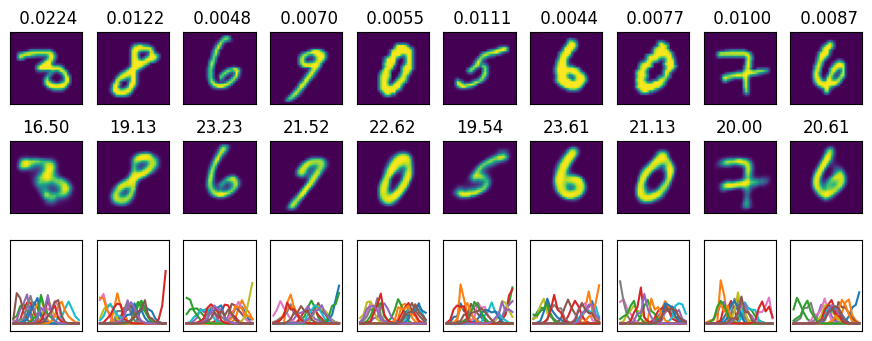

In [15]:
### Check reconstruction
# test
plt.figure()
save_path_str = f"{out_path_name}__rec_test.jpg"
check_reconstruction(model, test_ds, device, C_H_W=C_H_W)
# plt.title(save_path_str)
plt.savefig(save_path_str), print("Figure was saved:", save_path_str) #, plt.close()

# train
plt.figure()
save_path_str = f"{out_path_name}__rec_train.jpg"
check_reconstruction(model, train_ds, device, C_H_W=C_H_W)
# plt.title(save_path_str)
plt.savefig(save_path_str), print("Figure was saved:", save_path_str) #, plt.close()


# plt.savefig(f"{out_path_name}__rec_train.jpg")
# print("Figure was saved:", f"{out_path_name}__rec_train.jpg")
# plt.close()
#################

In [14]:
### MSE and PSNR scores
## Calculate reconstruction
# MSE and PSNR
mse_test, psnr_test = get_MSE_PSNR_score(decoded_2d2, X_full_test)
mse_train, psnr_train = get_MSE_PSNR_score(decoded_2d1, X_full_train)

score_str = f"MSE: {mse_test:.4f} ({mse_train:.4f});   " + f"PSNR: {psnr_test:.2f} ({psnr_train:.2f});   "
update_out_file(score_str, out_file_path, print_=True)
#########################


MSE: 0.0083 (0.0081);   PSNR: 20.81 (20.92);   



In [ ]:
   
   
### FID reconstruction train and test
print()
# test

checkpoint_path = checkpoint_test_dataset_path
r_fid_value = calculate_FID(X_full_test, decoded_2d2, TEST_BATCH_SIZE_SMALL, device, fid_class=None, transform=prepare_to_FID,
                            checkpoint_real_path=checkpoint_path)
print(f"Rec FID test: {r_fid_value :.2f}")

#train
checkpoint_path = checkpoint_train_dataset_path
if (checkpoint_path is not None) and (checkpoint_path != ''):
    r_fid_train = None
else:
    r_fid_train = ManualFID(device=device)
    
r_fid_value_train = calculate_FID(X_full_train, decoded_2d1, TEST_BATCH_SIZE_SMALL, device, fid_class=r_fid_train,
                                  transform=prepare_to_FID, checkpoint_real_path=checkpoint_path)
print(f"Rec FID train: {r_fid_value_train :.2f}")

score_str = f"Rec FID: {r_fid_value:.2f} ({r_fid_value_train:.2f})"
update_out_file(score_str, out_file_path, print_=True)

######################

# Generation

In [ ]:
print("\n\nGeneration test:")
torch.cuda.empty_cache()

# setup distributions
device_fid = DEVICE
model = model.to(device)
# Setup generating

dataset_list = []
dataset_names = []
ground_truth = X_full_train.detach().cpu()
# N_samples = ground_truth.shape[0]
N_samples = N_FAKE_SAMPLES
print("N_samples =", N_samples)


In [ ]:
###########################
# Generating samples Truth
dataset_truth = ground_truth # full dataset
dataset_list +=[dataset_truth]
dataset_names += ['Truth']
print(f"{dataset_names[-1]} samples = ", dataset_list[-1].shape[0])


In [ ]:

# Generating samples from autoencoders
model_dataset = gen_gm_dataset(model, encoded_out_dim1, device, n_components=1, total_size=N_samples,
                               batch_size=TEST_BATCH_SIZE_SMALL, C_H_W=C_H_W, max_iter=1000)
dataset_list +=[model_dataset]
dataset_names += [MODEL_TYPE + '_gm1']
print(f"{dataset_names[-1]} samples = ", dataset_list[-1].shape[0])

In [ ]:
# Generating samples from autoencoders
model_dataset = gen_gm_dataset(model, encoded_out_dim1, device, n_components=N_GM_COMPONENTS, total_size=N_samples,
                               batch_size=TEST_BATCH_SIZE_SMALL, C_H_W=C_H_W, max_iter=1000)
dataset_list +=[model_dataset]
dataset_names += [MODEL_TYPE + f'_gm{N_GM_COMPONENTS}']
print(f"{dataset_names[-1]} samples = ", dataset_list[-1].shape[0])
###################

In [ ]:

#### display 
print('\nDisplaying generation')
display_datasets(dataset_list, dataset_names)
save_path_str = f"{out_path_name}__gen.jpg"
# plt.title(save_path_str)
plt.savefig(save_path_str), print("Figure was saved:", save_path_str), plt.close()
#################

In [ ]:
#### FID calculation
print("\n\n")
print("Generation FID  calculations:")
torch.cuda.empty_cache()

checkpoint_path = checkpoint_train_dataset_path

# can be removed becoause we can use checkpoint!
if (checkpoint_path is not None) and (checkpoint_path != ''):
    print("Init m_fid because of checkpoint")
    m_fid = ManualFID(device=device_fid)
    imgs_real = dataset_list[0]
else:
    try:
        m_fid = r_fid_train
        print("m_fid <--- r_fid_train ")
        m_fid.to(device_fid)
        imgs_real = None
    except:
        print("Init m_fid")
        m_fid = ManualFID(device=device_fid)
        imgs_real = dataset_list[0]
    

In [ ]:
     
# GM1
imgs_fake = dataset_list[1]
m_fid_value = calculate_FID(imgs_real, imgs_fake, TEST_BATCH_SIZE_SMALL, device_fid, fid_class=m_fid, transform=prepare_to_FID,
                            checkpoint_real_path=checkpoint_path)
print("fake:", m_fid_value, '\n')


In [ ]:
#GM{N_GM_COMPONENTS}
imgs_fake = dataset_list[2]
m_fid_value_gm = calculate_FID(None, imgs_fake, TEST_BATCH_SIZE_SMALL, device_fid, fid_class=m_fid, transform=prepare_to_FID)
print(f"fake gm{N_GM_COMPONENTS}:", m_fid_value_gm, '\n')

In [ ]:
score_str = f"FID gm1: {m_fid_value :.2f};   FID gm{N_GM_COMPONENTS}: {m_fid_value_gm :.2f}"
# score_str = f"FID gm1: {m_fid_value :.2f} \nFID gm{N_GM_COMPONENTS}: {m_fid_value_gm :.2f}"
update_out_file(score_str, out_file_path, print_=True)